- RMSD
- RMSF
- PCA
- binding mode
- MM/PBSA  

backbone, ligand, Zn に対して取得する

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import nglview as nv
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

import MDAnalysis as mda
import MDAnalysis.transformations as trans
from MDAnalysis.analysis import align, rms, pca, diffusionmap, distances
from MDAnalysis.analysis.hydrogenbonds import hbond_analysis

/opt/miniconda3/envs/mdenv/lib/python3.11/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
log_df = pd.read_csv("result/log.txt",sep="\t")

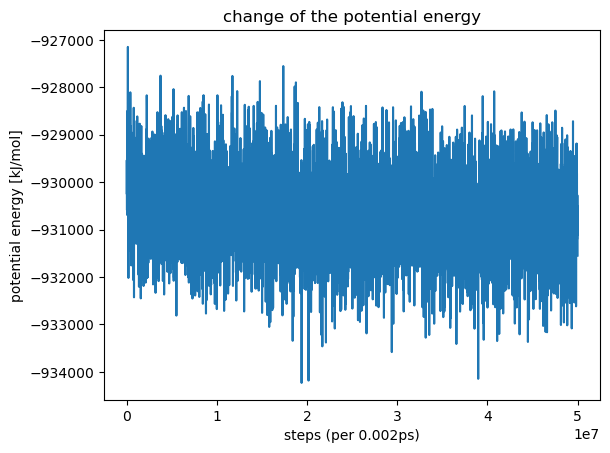

In [3]:
x = log_df["Step"]
y = log_df["Potential Energy (kJ/mole)"]
plt.plot(x,y)
plt.title("change of the potential energy")
plt.xlabel("steps (per 0.002ps)")
plt.ylabel("potential energy [kJ/mol]")
plt.show()

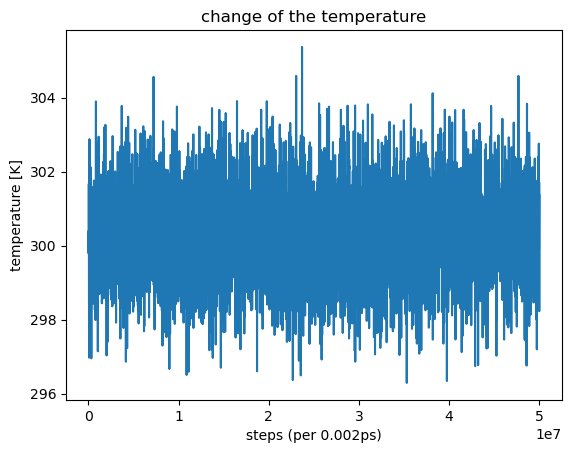

In [4]:
x = log_df["Step"]
y2 = log_df["Temperature (K)"]
plt.plot(x, y2)
plt.title("change of the temperature")
plt.xlabel("steps (per 0.002ps)")
plt.ylabel("temperature [K]")
plt.show()

---

In [50]:
# トラジェクトリの整備
md_universe = mda.Universe("data/minimized.pdb","result/trajectory.dcd")
protein = md_universe.select_atoms("protein")
ligand = md_universe.select_atoms("resname UNK")
zinc = md_universe.select_atoms("resname ZN")
transforms = [trans.center_in_box(protein), trans.wrap(ligand), trans.wrap(zinc)]
md_universe.trajectory.add_transformations(*transforms)

/opt/miniconda3/envs/mdenv/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:290: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/opt/miniconda3/envs/mdenv/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [7]:
alignment = align.AlignTraj(mobile=md_universe,reference=md_universe,select="name CA",in_memory=True)
alignment.run()

In [53]:
view = nv.show_mdanalysis(md_universe)
view.add_representation("point","resname HOH")
view

NGLWidget(max_frame=4999)

In [10]:
md_universe.trajectory[0]
RMSD_analysis = rms.RMSD(md_universe,reference=md_universe,select="backbone",
                         groupselections=["protein","resname UNK","resname ZN"],ref_frame=0)
RMSD_analysis.run()

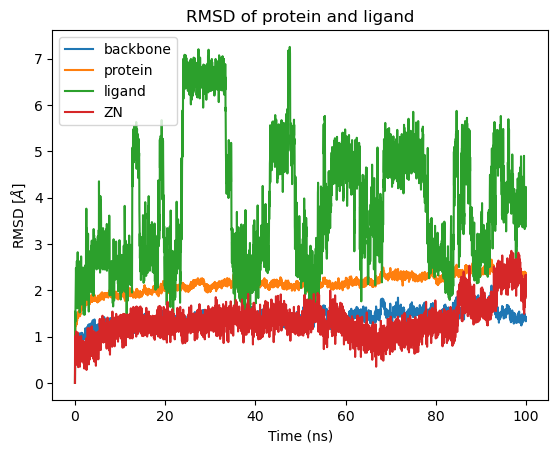

In [12]:
# backbone基準としたRMSDで描画
column_names = ['frame', 'time(ps)', 'backbone', 'protein', 'ligand',"ZN"]
rmsd_df = pd.DataFrame(np.round(RMSD_analysis.results.rmsd, 2), columns = column_names)
rmsd_df["time(ns)"] = rmsd_df["time(ps)"] / 1000
plt.plot(rmsd_df['time(ns)'], rmsd_df['backbone'], label="backbone")
plt.plot(rmsd_df['time(ns)'], rmsd_df['protein'], label="protein")
plt.plot(rmsd_df['time(ns)'], rmsd_df['ligand'], label="ligand")
plt.plot(rmsd_df['time(ns)'], rmsd_df['ZN'], label="ZN")
plt.legend(loc="upper left")
plt.xlabel("Time (ns)")
plt.ylabel("RMSD [$\AA$]")
plt.title("RMSD of protein and ligand")

plt.show()

In [13]:
pairwase_protein = diffusionmap.DistanceMatrix(md_universe, select = "protein")
pairwase_protein.run()
dist_matrix_protein = pairwase_protein.results.dist_matrix

pairwase_ligand = diffusionmap.DistanceMatrix(md_universe, select = "resname UNK")
pairwase_ligand.run()
dist_matrix_ligand = pairwase_ligand.results.dist_matrix

pairwase_zn = diffusionmap.DistanceMatrix(md_universe, select = "resname ZN")
pairwase_zn.run()
dist_matrix_zn = pairwase_zn.results.dist_matrix

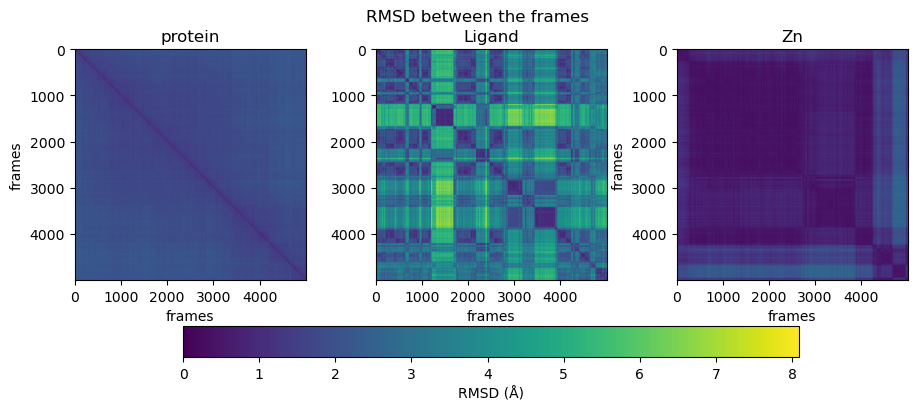

In [14]:
max_dist = max(np.amax(dist_matrix_ligand), np.amax(dist_matrix_protein))

fig, ax = plt.subplots(1, 3, figsize=(11,4))
fig.suptitle("RMSD between the frames")

img1 = ax[0].imshow(dist_matrix_protein, cmap="viridis", vmin=0, vmax=max_dist)
ax[0].title.set_text("protein")
ax[0].set_xlabel("frames")
ax[0].set_ylabel("frames")

img2 = ax[1].imshow(dist_matrix_ligand, cmap="viridis", vmin=0, vmax=max_dist)
ax[1].title.set_text("Ligand")
ax[1].set_xlabel("frames")

img3 = ax[2].imshow(dist_matrix_zn, cmap="viridis", vmin=0, vmax=max_dist)
ax[2].title.set_text("Zn")
ax[2].set_xlabel("frames")
ax[2].set_ylabel("frames")

fig.colorbar(img2, ax=ax, orientation="horizontal", fraction=0.1, label="RMSD (Å)")
plt.show()

---

## ProLIF

In [15]:
import prolif as plf
from prolif.plotting.network import LigNetwork
from prolif.plotting.complex3d import Complex3D
from prolif.plotting.barcode import Barcode

In [16]:
lig = md_universe.atoms.select_atoms("resname UNK")
prot = md_universe.atoms.select_atoms("protein")
fp = plf.Fingerprint()
fp.run(md_universe.trajectory[::10],lig,prot)

  0%|          | 0/500 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x7fc6c0c37690>

In [17]:
df_fp = fp.to_dataframe()
lmol = plf.Molecule.from_mda(lig)
net = LigNetwork.from_fingerprint(fp,lmol,display_all=True,threshold=0.3)
net.display()

<Axes: xlabel='Frame'>

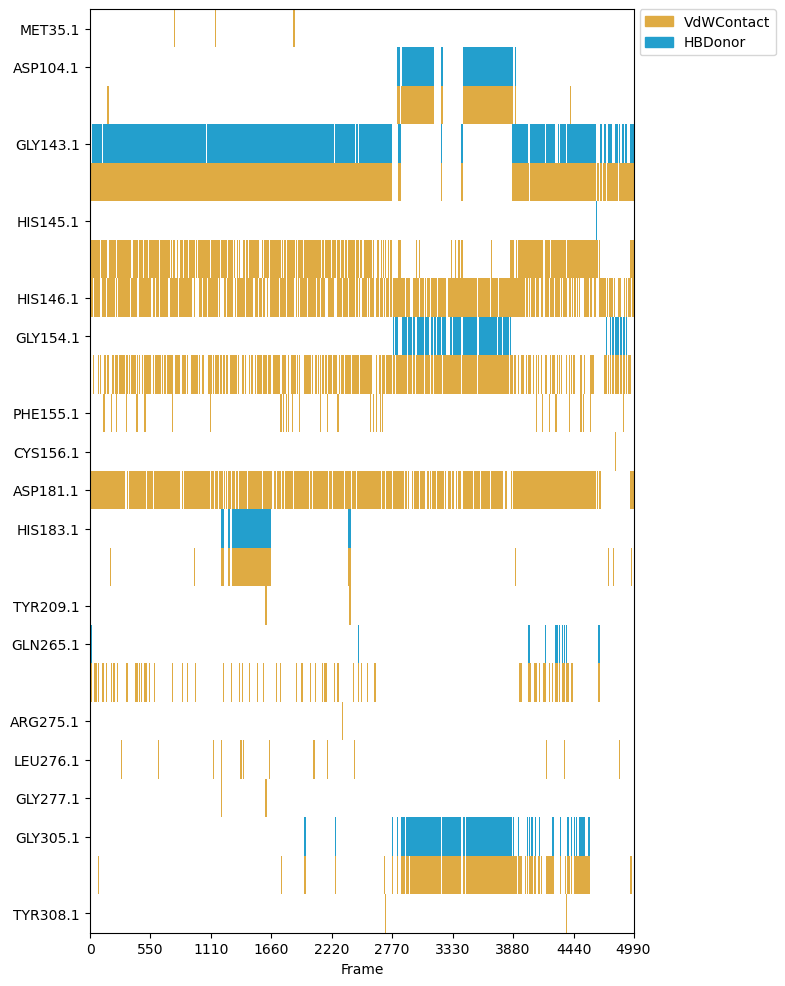

In [18]:
barcode = Barcode(df_fp)
barcode.display()

In [31]:
md_universe.trajectory[0]
residue = md_universe.select_atoms("resid 181 and resname ASP and name OD1")
ligand = md_universe.select_atoms("resname UNK and name O1x")
dist = distances.dist(residue,ligand)
print(dist)

[[181.        ]
 [  0.        ]
 [  2.78027497]]


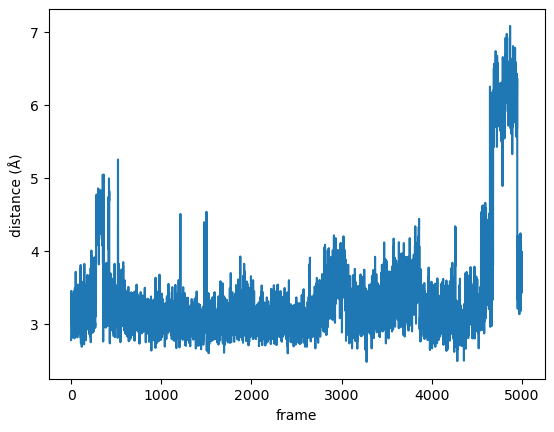

In [32]:
distlist = []
for _ in md_universe.trajectory:
    dist_t = distances.dist(residue,ligand)[2][0]
    distlist.append(dist_t)
plt.plot(distlist)
plt.ylabel("distance (Å)")
plt.xlabel("frame")
plt.show()

---

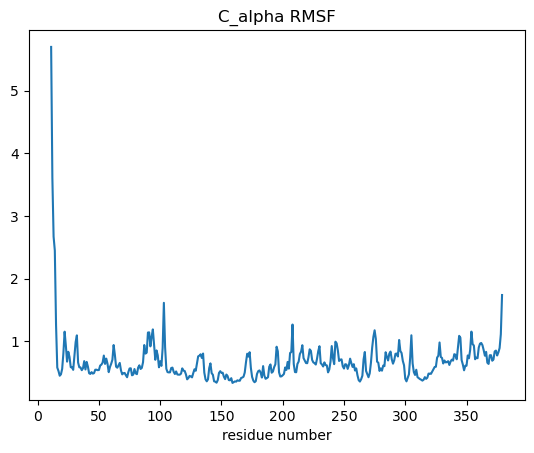

In [33]:
C_alphas = md_universe.select_atoms("name CA")
RMSF_analysis = rms.RMSF(C_alphas)
RMSF_analysis.run()

residue_numbers = C_alphas.resnums
plt.plot(residue_numbers, RMSF_analysis.results.rmsf)
plt.title("C_alpha RMSF")
plt.xlabel("residue number")
plt.show()

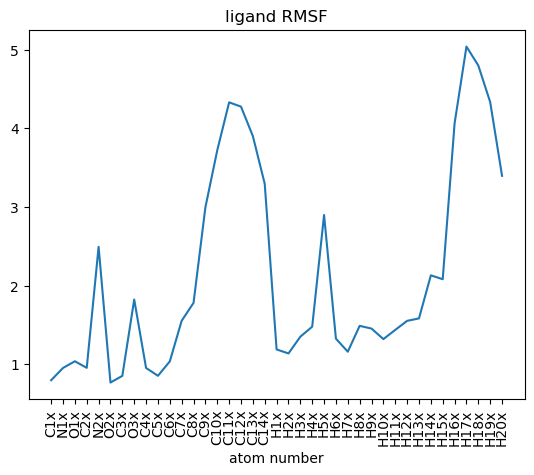

In [34]:
ligands = md_universe.select_atoms("resname UNK")
RMSF_analysis = rms.RMSF(ligands)
RMSF_analysis.run()
lig_atom_names = [v.name for v in ligands.atoms]

atom_numbers = ligands.n_atoms
plt.plot(range(atom_numbers), RMSF_analysis.results.rmsf)
plt.xticks(range(atom_numbers),lig_atom_names,rotation=90)
plt.title("ligand RMSF")
plt.xlabel("atom number")
plt.show()

In [35]:
mol = Chem.MolFromPDBFile("data/vorinostat.pdb")
with open("data/vorinostat.pdb") as f:
    text = f.read().split("\n")
text = [v.split(" ") for v in text]
text = [[v for v in x if v != ""] for x in text]
text = [v[2] for v in text]

atoms = mol.GetNumAtoms()
for idx, txt in zip(range(atoms),text):
    mol.GetAtomWithIdx(idx).SetProp("atomNote",txt)

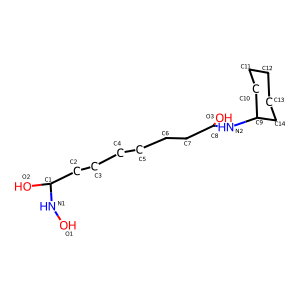

In [36]:
DrawingOptions.includeAtomNumbers = True
Chem.Draw.MolToImage(mol)

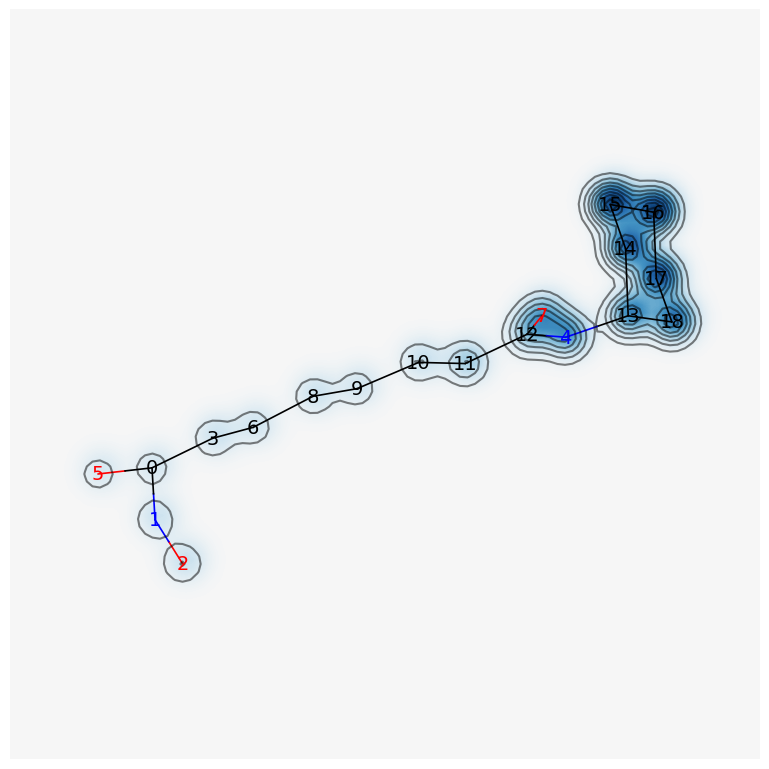

In [37]:
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol,weights=RMSF_analysis.results.rmsf,colorMap="RdBu",size=(300,300))

---

In [38]:
Ca_pca = pca.PCA(md_universe,select="name CA")
Ca_pca.run()

In [39]:
transformed = Ca_pca.transform(md_universe.select_atoms("name CA"), n_components=3)
print("shape of the array : ", transformed.shape)

shape of the array :  (5000, 3)


In [40]:
frame_time = md_universe.trajectory.dt
df = pd.DataFrame(transformed, columns=['PC1', 'PC2', 'PC3'])
df['Time (ps)'] = df.index * frame_time
df.head()

,PC1,PC2,PC3,Time (ps)
0,-11.042096,10.896032,4.295625,0.0
1,-11.692362,9.780253,4.491783,20.0
2,-11.946865,8.195816,3.230094,40.0
3,-11.680809,9.097106,4.786267,60.0
4,-11.498489,10.006874,5.286040,80.0


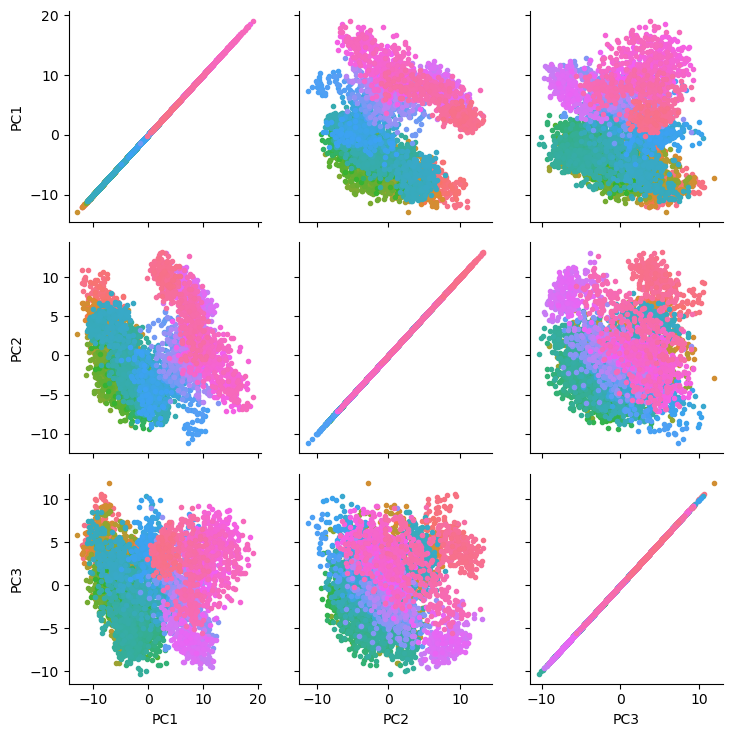

In [41]:
pair_grid_plot = sns.PairGrid(df, hue='Time (ps)')
pair_grid_plot.map(plt.scatter, marker='.')

In [42]:
proj_univ = []
for i in range(3):
    pc = Ca_pca.results.p_components[:,i]
    weight = transformed[:,i]
    mean_coord = Ca_pca.mean
    projected = np.outer(weight,pc) + mean_coord.flatten()
    coordinates = projected.reshape(len(weight),-1,3)
    proj = mda.Merge(md_universe.select_atoms("name CA"))
    proj.load_new(coordinates,order="fac")
    proj_univ.append(proj)

In [43]:
view = nv.show_mdanalysis(proj_univ[0].atoms)
view

NGLWidget(max_frame=4999)

In [78]:
view = nv.show_mdanalysis(proj_univ[1].atoms)
view

NGLWidget(max_frame=999)

In [44]:
Ca_pca = pca.PCA(md_universe,select="resname UNK")
Ca_pca.run()
transformed = Ca_pca.transform(md_universe.select_atoms("resname UNK"), n_components=3)
proj_univ_l = []
for i in range(3):
    pc = Ca_pca.results.p_components[:,i]
    weight = transformed[:,i]
    mean_coord = Ca_pca.mean
    projected = np.outer(weight,pc) + mean_coord.flatten()
    coordinates = projected.reshape(len(weight),-1,3)
    proj = mda.Merge(md_universe.select_atoms("resname UNK"))
    proj.load_new(coordinates,order="fac")
    proj_univ_l.append(proj)

In [84]:
view = nv.show_mdanalysis(proj_univ_l[2].atoms)
view

NGLWidget(max_frame=4999)